# Импорт библиотек

In [280]:
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nib
import torch
import torchvision.transforms as transforms
import cv2
from PIL import Image
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve
import scipy.signal as signal
import random

# Работа с данными

## Видеоряд

In [2]:
video_path = os.path.join(os.path.dirname(os.getcwd()), "src", "Film stimulus.mp4")

In [3]:
def video_to_frames():
    videocap = cv2.VideoCapture(video_path)
    success, frame = videocap.read()
    count = 1
    while success:
        cv2.imwrite(os.path.join(os.path.dirname(os.getcwd()),
                                "src", "frames", f"frame_{count}.jpg"), frame)    
        success, frame = videocap.read()
        count += 1

In [86]:
video_to_frames()

In [4]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True, verbose=False)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(2048, 2048)

c:\Users\kisnikser\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\kisnikser\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
def frames_to_tensors():
    for i in range(1, 9751):
        frame_path = os.path.join(os.path.dirname(os.getcwd()), "src", "frames", f"frame_{i}.jpg")
        frame = Image.open(frame_path)
        frame_tensor = preprocess(frame)
        frame_tensor = frame_tensor.unsqueeze(0)
        yield frame_tensor

In [7]:
def tensors_to_vectors():
    for frame_tensor in frames_to_tensors():
        # передача картинки в модель и получение выходных данных
        with torch.no_grad():
            output = model(frame_tensor)
        # преобразование выходных данных в вектор
        vector = output.numpy().flatten()
        yield vector

In [8]:
#vector_list = [vector for vector in tensors_to_vectors()]
#np.save("vector_list", vector_list)
vector_list = np.load("vector_list.npy")

## Снимки фМРТ

In [9]:
subs_with_fmri = ['04', '07', '08', '09', '11', '13', '14', '15', '16', '18',\
                  '22', '24', '27', '28', '29', '31', '35', '41', '43', '44',\
                  '45', '46', '47', '51', '52', '53', '55', '56', '60', '62']

In [475]:
def subs_to_tensors():
    for sub in subs_with_fmri:
        sub_path = os.path.join(os.path.dirname(os.getcwd()), "src", "ds003688-download", f"sub-{sub}",\
                                "ses-mri3t", "func", f"sub-{sub}_ses-mri3t_task-film_run-1_bold.nii.gz")
        sub_scan = nib.load(sub_path)
        sub_data = sub_scan.get_fdata()
        sub_tensor = torch.tensor(sub_data)
        yield sub_tensor
        

In [476]:
def get_sub_tensor(nsub: str):
    for sub, sub_tensor in zip(subs_with_fmri, subs_to_tensors()):
        if nsub != sub:
            continue
        else:
            return sub_tensor

In [277]:
sub_tensor = next(subs_to_tensors())
X, Y, Z, N = sub_tensor.shape
# X = 40
# Y = 64
# Z = 64
# N = 641

In [477]:
def scans_to_tensors(nsub: str):
    sub_tensor = get_sub_tensor(nsub)
    for i in range(sub_tensor.shape[3]):
        scan_tensor = sub_tensor[:, :, :, i]
        yield scan_tensor.numpy()

# Построение линейной модели

## Рассмотрение конкретного испытуемого

In [554]:
# функция, которая на вход получает
# dt - гиперпараметр, время задержки
# sub - номер испытуемого
# preprocessing - индикатор того, нужно ли предобрабатывать данные
# ptype - тип предобработки
# compression - индикатор того, нужно ли сжатие снимка фМРТ
# coef - во сколько раз сжимается снимок фМРТ
# train_size - часть выборки, выделенная под train

def sub_linear_prediction(dt=5, sub='04', preprocessing=True, ptype="normalization",\
                            compression=True, coef=8, train_size=0.7):
    # частота видео
    nu = 25
    # частота снимков фМРТ
    mu = 641. / 390.
    # размерности снимка фМРТ до сжатия
    m, n, k = 40, 64, 64
    # длина вектора признакового описания изображения
    d = 2048
    # N - количество снимков fMRI
    N = 641 - int(mu * dt)
    # (номер изображения, номер снимка)
    pairs = [(int(m * nu / mu), int(mu * dt + m)) for m in range(N)]

    # тензор снимка фМРТ
    sub_tensor = get_sub_tensor(sub)
    
    # сжатие снимка фМРТ
    if compression:
        maxpool = torch.nn.MaxPool3d(kernel_size=coef, stride=coef)
        input_tensor = sub_tensor.permute(3, 0, 1, 2)
        output_tensor = maxpool(input_tensor).permute(1, 2, 3, 0)
    else:
        output_tensor = sub_tensor

    d1, d2, d3, d4 = output_tensor.shape

    # список тензоров снимков фМРТ
    scans_list = [output_tensor[:, :, :, i] for i in range(output_tensor.shape[3])]

    # список снимков фМРТ, развернутых в векторы
    voxels = [scan.reshape(d1 * d2 * d3).numpy() for scan in scans_list]

    # (изображение, снимок)
    data = [(vector_list[n], voxels[k]) for n, k in pairs]

    # train, test
    l = int(train_size * d4)
    train, test = data[:l], data[l:]

    # preprocessing
    def preprocess(v, ptype="normalization"):
        if ptype == "normalization":
            return (v - v.min()) / (v.max() - v.min())
        elif ptype == "standardization":
            return (v - v.mean()) / v.std()
        
    if preprocessing:
        train = [(pair[0], preprocess(pair[1], ptype)) for pair in train]
        test = [(pair[0], preprocess(pair[1], ptype)) for pair in test]

    # линейная регрессия
    linreg = LinearRegression()

    # матрица весов модели
    W = []

    X_train = np.array([pair[0] for pair in train])
    Y_train = np.array([pair[1] for pair in train]).T
    X_test = np.array([pair[0] for pair in test]).T
    Y_test = np.array([pair[1] for pair in test]).T

    for i in range(d1 * d2 * d3):
        # создать столбец Y
        Y_train_vector = Y_train[i]
        # получить вектор w_i
        linreg.fit(X_train, Y_train_vector)
        w = linreg.coef_
        # добавить его в матрицу W = [w_i], i = 0, ..., d1 * d2 * d3
        W.append(w)

    W = np.array(W)
    
    Y_train_predicted = W @ X_train.T
    Y_test_predicted = W @ X_test

    # усреднение по всем столбцам (снимкам фМРТ)
    def MSE(A):
        m, n = A.shape
        return 1 / n * np.linalg.norm(A, "fro") ** 2
    
    MSE_train = MSE(Y_train_predicted - Y_train)
    MSE_test = MSE(Y_test_predicted - Y_test)

    # сохранение выхода в файл
    output = np.array([MSE_train, MSE_test, Y_test, Y_test_predicted, d1, d2, d3], dtype=object)
    output_name = f"output-{dt}-{sub}"
    if preprocessing:
        output_name = output_name + f"-{ptype}"
    if compression:
        output_name = output_name + f"-{coef}"
    np.save(output_name, output, allow_pickle=True)

    return output

In [1172]:
output = sub_linear_prediction(dt=4, sub='04', preprocessing=True, ptype="normalization",\
                                compression=True, coef=2, train_size=0.7)
MSE_train, MSE_test, Y_test, Y_test_predicted, d1, d2, d3 = output

In [1129]:
output = np.load("output-5-04-normalization-2.npy", allow_pickle=True)
MSE_train, MSE_test, Y_test, Y_test_predicted, d1, d2, d3 = output

In [1173]:
print(f"MSE_train = {MSE_train:.2f}, MSE_test = {MSE_test:.2f}")

MSE_train = 1349.41, MSE_test = 1382.49


## Зависимость MSE на тестовой выборке от гиперпараметра $\Delta t$

In [1074]:
t = [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5]
mse = []

for dt in t:
    output = sub_linear_prediction(dt=dt, sub='04', preprocessing=True, ptype="normalization",\
                                compression=True, coef=4, train_size=0.7)
    MSE_test = output[1]
    mse.append(MSE_test)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


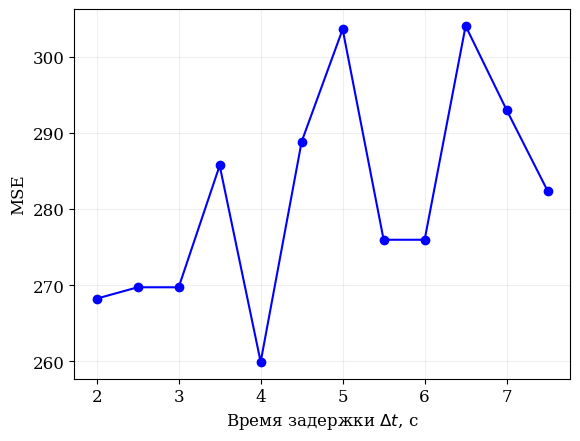

In [1089]:
plt.rcParams.update({'font.size': 12})
plt.rc("font", family='serif')

plt.plot(t, mse, marker='o', color="blue")
#plt.title("График зависимости MSE($\Delta t$)")
plt.xlabel("Время задержки $\Delta t$, с")
plt.ylabel("MSE")
plt.grid(alpha=0.2)

figures = "../figures"
plt.savefig(
    os.path.join(figures, "MSE_dt.eps"),
    bbox_inches="tight")

## Test (original)

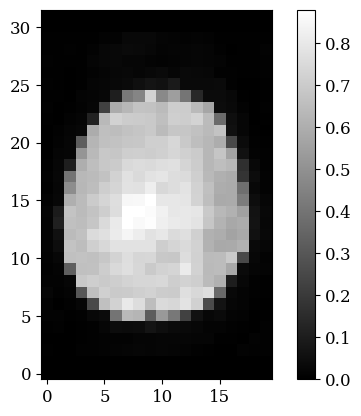

In [1278]:
fmri_test_vector = Y_test.T[37]
fmri_test = fmri_test_vector.reshape((d1, d2, d3))

plt.imshow(fmri_test[:, :, 24].T, cmap="gray", origin="lower")
plt.colorbar()

plt.savefig(
    os.path.join(figures, "sub-04-4-2-_-_-24-orig.eps"),
    bbox_inches="tight")

## Test (predicted)

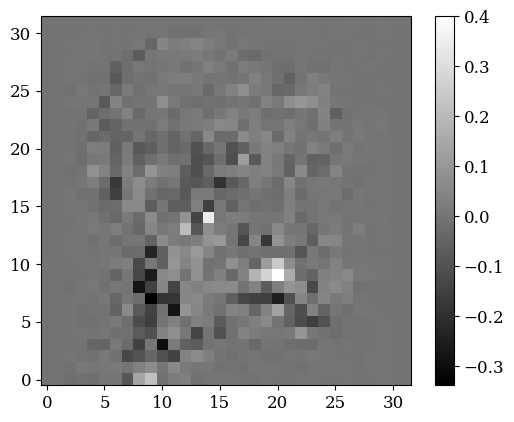

In [1249]:
fmri_predicted_vector = Y_test_predicted.T[37]
fmri_predicted = fmri_predicted_vector.reshape((d1, d2, d3))

plt.imshow(fmri_predicted[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()

### Pruning

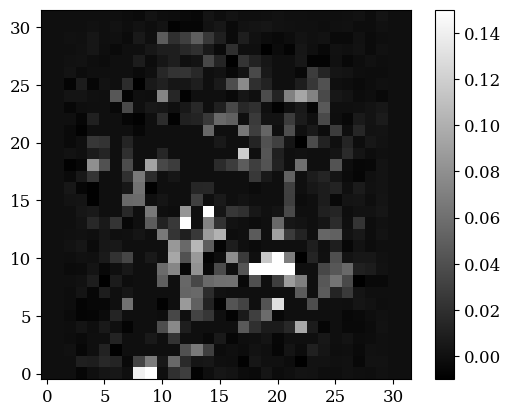

In [1259]:
mask_min = fmri_predicted < -0.01
mask_max = fmri_predicted > 0.15
mask_mm = mask_min + mask_max

fmri_predicted_pruning = np.zeros_like(fmri_predicted)
fmri_predicted_pruning[~mask_mm] = fmri_predicted[~mask_mm]
fmri_predicted_pruning[mask_min] = 0
fmri_predicted_pruning[mask_max] = 0.15

plt.imshow(fmri_predicted_pruning[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()

### Gauss

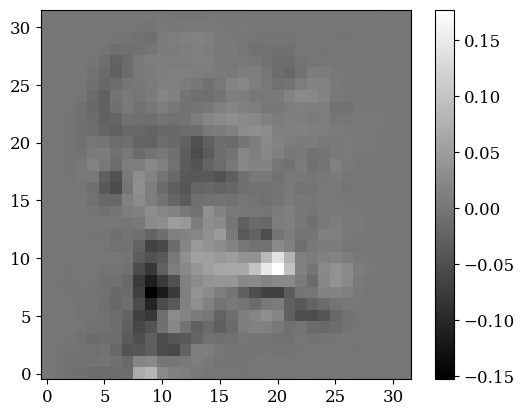

In [1260]:
sigma = 0.7

fmri_predicted_gauss = gaussian_filter(fmri_predicted, sigma=sigma)

plt.imshow(fmri_predicted_gauss[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()

### Pruning + Gauss

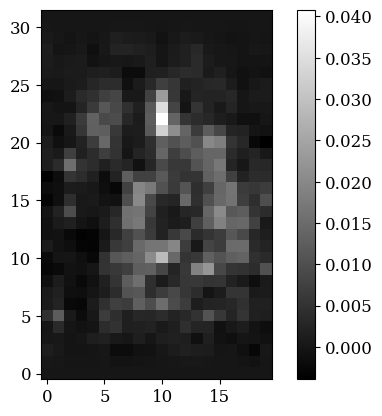

In [1279]:
sigma = 0.6

fmri_predicted_pruning_gauss = gaussian_filter(fmri_predicted_pruning, sigma=sigma)

plt.imshow(fmri_predicted_pruning_gauss[:, :, 24].T, cmap="gray", origin="lower")
plt.colorbar()

plt.savefig(
    os.path.join(figures, "sub-04-4-2-_-_-24-pred-pg.eps"),
    bbox_inches="tight")

### Averaging over adjacent voxels

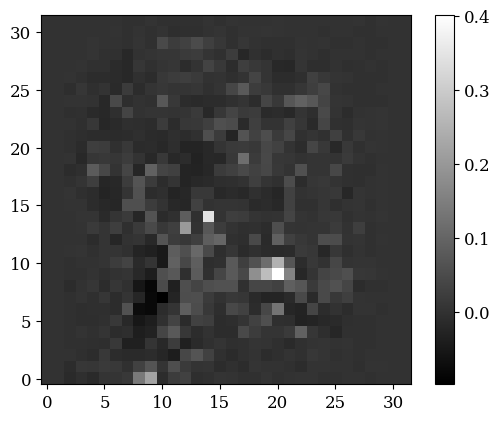

In [1243]:
# усредняющее ядро 3x3x3
kernel = np.ones((3, 3, 3)) / 27

fmri_predicted_average = np.zeros_like(fmri_predicted)
fmri_predicted_average[mask_mm] = convolve(fmri_predicted, kernel, mode='same')[mask_mm]
fmri_predicted_average[~mask_mm] = fmri_predicted[~mask_mm]

plt.imshow(fmri_predicted_average[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()

### Median filter

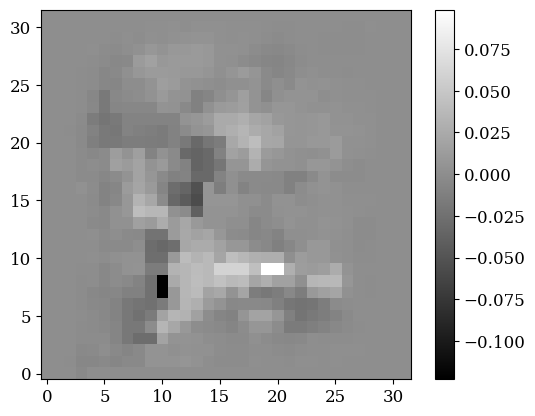

In [1244]:
# применим медианный фильтр с размером окна 3x3x3
fmri_predicted_median = signal.medfilt(fmri_predicted, kernel_size=3)

plt.imshow(fmri_predicted_median[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()

### Pruning + Median filter

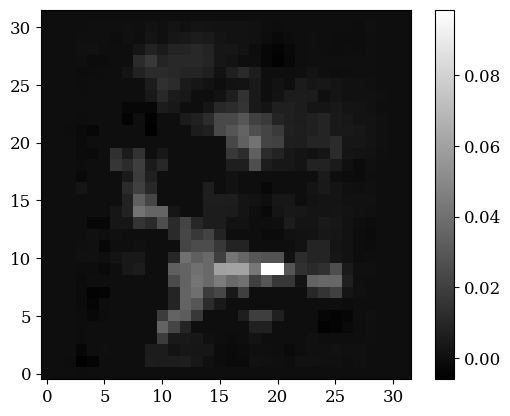

In [1247]:
fmri_predicted_pruning_median = signal.medfilt(fmri_predicted_pruning, kernel_size=3)

plt.imshow(fmri_predicted_pruning_median[10, :, :].T, cmap="gray", origin="lower")
plt.colorbar()